In [24]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [25]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [26]:
NUM_CLASSES = 26

# Dataset reading

In [27]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [28]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [30]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [31]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 42)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                860       
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 26)                286       
                                                                 
Total params: 1,356
Trainable params: 1,356
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=100, verbose=1)

In [33]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [34]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 97/129 [=====================>........] - ETA: 0s - loss: 3.1063 - accuracy: 0.0859
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
129/129 [==============================] - 1s 3ms/step - loss: 3.0377 - accuracy: 0.1116 - val_loss: 2.6427 - val_accuracy: 0.3085
Epoch 2/1000
112/129 [=========================>....] - ETA: 0s - loss: 2.5164 - accuracy: 0.2622
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
129/129 [==============================] - 0s 3ms/step - loss: 2.4885 - accuracy: 0.2668 - val_loss: 1.9630 - val_accuracy: 0.4438
Epoch 3/1000
115/129 [=========================>....] - ETA: 0s - loss: 2.0505 - accuracy: 0.3409
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
129/129 [==============================] - 0s 3ms/step - loss: 2.0353 - accuracy: 0.3432 - val_loss: 1.5725 - val_accuracy: 0.5372
Epoch 4/1000
128/129 [============================>.] - ETA: 0s - loss: 1.8023 - accu

In [35]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

43/43 [==============================] - 0s 2ms/step - loss: 0.2592 - accuracy: 0.9079


In [36]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [37]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 83ms/step
[2.0977387e-03 4.3138124e-17 3.3936578e-09 1.8785760e-09 1.6584694e-03
 1.1749780e-12 4.1279140e-20 6.8497901e-22 5.7753124e-07 4.5494738e-07
 3.5794174e-12 3.1782530e-13 4.2550552e-01 4.8695436e-01 1.7434079e-06
 2.9449290e-18 3.8321367e-15 7.8039614e-10 4.2531481e-03 7.9524867e-02
 4.4129243e-19 3.2068134e-27 7.9718845e-22 2.8924990e-06 6.9872854e-08
 3.4707901e-21]
13


# Confusion matrix

171/171 [==============================] - 0s 1ms/step


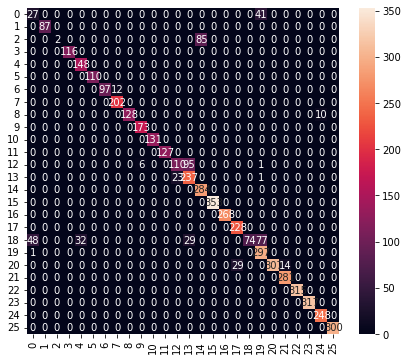

Classification Report
              precision    recall  f1-score   support

           0       0.36      0.40      0.37        68
           1       1.00      1.00      1.00        87
           2       1.00      0.02      0.04        87
           3       1.00      1.00      1.00       116
           4       0.82      1.00      0.90       148
           5       1.00      1.00      1.00       110
           6       1.00      0.89      0.94       109
           7       0.94      1.00      0.97       202
           8       1.00      0.93      0.96       138
           9       0.97      1.00      0.98       173
          10       1.00      1.00      1.00       131
          11       1.00      1.00      1.00       127
          12       0.83      0.52      0.64       212
          13       0.66      0.91      0.76       261
          14       0.77      1.00      0.87       284
          15       1.00      1.00      1.00       353
          16       1.00      1.00      1.00       268
     

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [39]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [40]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

2024-05-31 03:05:38.548575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_2' with dtype float and shape [?,42]
	 [[{{node input_2}}]]
2024-05-31 03:05:38.620139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,42]
	 [[{{node inputs}}]]
2024-05-31 03:05:38.640659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_2' with dtype float and shape [?,42]
	 [[{{node input_2}}]]
2024-05-31 03:0

INFO:tensorflow:Assets written to: /tmp/tmpjsunw100/assets


INFO:tensorflow:Assets written to: /tmp/tmpjsunw100/assets
2024-05-31 03:05:39.641541: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-05-31 03:05:39.641571: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-05-31 03:05:39.641792: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjsunw100
2024-05-31 03:05:39.643290: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-05-31 03:05:39.643308: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjsunw100
2024-05-31 03:05:39.649269: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-05-31 03:05:39.707180: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmpjsunw100
2024-05-31 03:05:39.720708: I tensorflow/cc/saved_model/loader.cc:314] SavedModel

7540

# Inference test

In [41]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [42]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [43]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [44]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 42 µs, sys: 3 µs, total: 45 µs
Wall time: 102 µs


In [45]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.0977422e-03 4.3138501e-17 3.3936554e-09 1.8785815e-09 1.6584687e-03
 1.1749794e-12 4.1279188e-20 6.8497714e-22 5.7753300e-07 4.5494880e-07
 3.5794351e-12 3.1782687e-13 4.2550519e-01 4.8695493e-01 1.7434116e-06
 2.9449435e-18 3.8321554e-15 7.8039997e-10 4.2531467e-03 7.9524808e-02
 4.4129631e-19 3.2068658e-27 7.9718936e-22 2.8925106e-06 6.9873060e-08
 3.4708204e-21]
13
